# below to draw distribution plot

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


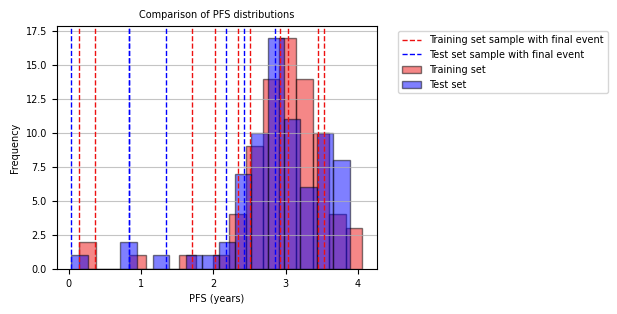

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets
data = pd.read_csv('trainingset.csv')
test_data = pd.read_csv('testset.csv')

# Define the number of bins for the histogram
num_bins_comparison = int(np.sqrt(len(data['futime'])) * 2)

# Convert dimensions from mm to inches for figsize
width_inches = 105 / 25.4
height_inches = 80 / 25.4

# Create the comparison plot
plt.figure(figsize=(width_inches, height_inches))

# Plot for the training set
plt.hist(data['futime'], bins=num_bins_comparison, color='#ed1111', edgecolor='black', label='Training set', alpha=0.5)

# Plot for the test set
plt.hist(test_data['futime'], bins=num_bins_comparison, color='#0000ff', edgecolor='black', label='Test set', alpha=0.5)

# Add vertical lines for the training set where 'fustat' is 1
for futime in data[data['fustat'] == 1]['futime']:
    plt.axvline(futime, color='#ed1111', linestyle='dashed', linewidth=1, label='Training set sample with final event' if futime == data[data['fustat'] == 1]['futime'].iloc[0] else "")

# Add vertical lines for the test set where 'fustat' is 1
for futime in test_data[test_data['fustat'] == 1]['futime']:
    plt.axvline(futime, color='#0000ff', linestyle='dashed', linewidth=1, label='Test set sample with final event' if futime == test_data[test_data['fustat'] == 1]['futime'].iloc[0] else "")

# Add title and labels with specified font size and Helvetica font
plt.title('Comparison of PFS distributions', fontsize=7, fontname='Helvetica')
plt.xlabel('PFS (years)', fontsize=7, fontname='Helvetica')
plt.ylabel('Frequency', fontsize=7, fontname='Helvetica')

# Customize the tick labels for both axes
plt.xticks(fontsize=7, fontname='Helvetica')
plt.yticks(fontsize=7, fontname='Helvetica')

# Add the legend outside of the plot
legend = plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=7)
for text in legend.get_texts():
    text.set_fontsize(7)
    text.set_fontname('Helvetica')

# Add grid
plt.grid(axis='y', alpha=0.75)

# Save the figure
plt.savefig('new_size_futime_legend_fustat_labels_histogram_outsideplot.png', dpi=400, bbox_inches='tight')

# Display the plot
plt.show()


# below is backup of comparision clincial data of two sets （not run）

In [3]:
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency

# Function to read data
def read_data(file_name):
    return pd.read_csv(file_name)

# Function to merge datasets
def merge_data(data1, data2, key1, key2):
    return pd.merge(data1, data2, left_on=key1, right_on=key2)

# Function to summarize data
def summarize_data(df):
    summary = {}
    for column in df.columns:
        if column in ['id', 'pid']:
            continue
        if df[column].dropna().isin([0, 1]).all():
            counts = df[column].value_counts()
            summary[column] = {'0': counts.get(0, 0), '1': counts.get(1, 0)}
        else:
            summary[column] = {'mean': df[column].mean(), 'std': df[column].std()}
    return summary

# Function to perform Mann-Whitney U test
def perform_mann_whitney_u_test(train_data, test_data, column):
    try:
        stat, p = mannwhitneyu(train_data[column].dropna(), test_data[column].dropna())
        return {'statistic': stat, 'p-value': p}
    except Exception as e:
        return {'error': str(e)}

# Function to perform Chi-square test
def perform_chi_square_test(train_data, test_data, column):
    try:
        train_counts = train_data[column].value_counts()
        test_counts = test_data[column].value_counts()
        contingency_table = pd.DataFrame({column + "_train": train_counts, column + "_test": test_counts}).fillna(0)
        stat, p, dof, expected = chi2_contingency(contingency_table)
        return {'statistic': stat, 'p-value': p}
    except Exception as e:
        return {'error': str(e)}

# Function to create summary dataframe
def create_summary_dataframe(summary, test_results, dataset_type):
    summary_df = pd.DataFrame(summary).T
    summary_df['Type'] = summary_df.apply(lambda row: 'Continuous' if 'mean' in row else 'Binary', axis=1)
    
    # Add test results
    for column in summary_df.index:
        if column in test_results:
            result = test_results[column]
            if 'error' not in result:
                summary_df.loc[column, 'Test Statistic'] = result['statistic']
                summary_df.loc[column, 'P-value'] = result['p-value']
            else:
                summary_df.loc[column, 'Error'] = result['error']
    
    summary_df.columns = [f'{dataset_type} {col}' for col in summary_df.columns]
    return summary_df

# Main code to process the data and generate output file
if __name__ == "__main__":
    # Load the datasets
    training_set = read_data('trainingset.csv')
    test_set = read_data('testset.csv')
    clinical_data = read_data('clinicaldata.csv')

    # Merging the data
    # Ensuring the column names are consistent before merging
    training_set.rename(columns={'id': 'pid'}, inplace=True)
    test_set.rename(columns={'ID': 'pid'}, inplace=True)

    training_merged = merge_data(training_set, clinical_data, 'pid', 'pid')
    test_merged = merge_data(test_set, clinical_data, 'pid', 'pid')

    # Summarize the data
    training_summary = summarize_data(training_merged)
    test_summary = summarize_data(test_merged)

    # Perform statistical tests
    continuous_tests_results = {}
    binary_tests_results = {}

    columns = training_merged.columns.drop(['pid'])
    for column in columns:
        if training_merged[column].dropna().isin([0, 1]).all() and test_merged[column].dropna().isin([0, 1]).all():
            binary_tests_results[column] = perform_chi_square_test(training_merged, test_merged, column)
        else:
            continuous_tests_results[column] = perform_mann_whitney_u_test(training_merged, test_merged, column)

    # Create summary dataframes
    training_summary_df = create_summary_dataframe(training_summary, continuous_tests_results, 'Training')
    test_summary_df = create_summary_dataframe(test_summary, binary_tests_results, 'Test')

    # Combine the training and test summaries
    combined_summary_df = pd.concat([training_summary_df, test_summary_df], axis=1)

    # Save the combined DataFrame to a CSV file
    combined_summary_df.to_csv('backupresult_combined_statistical_summary_with_pvalues.csv')
    
    print("The combined statistical summary has been saved to 'combined_statistical_summary_with_pvalues.csv'")


The combined statistical summary has been saved to 'combined_statistical_summary_with_pvalues.csv'


# below is the codes to compare fPM score distributions

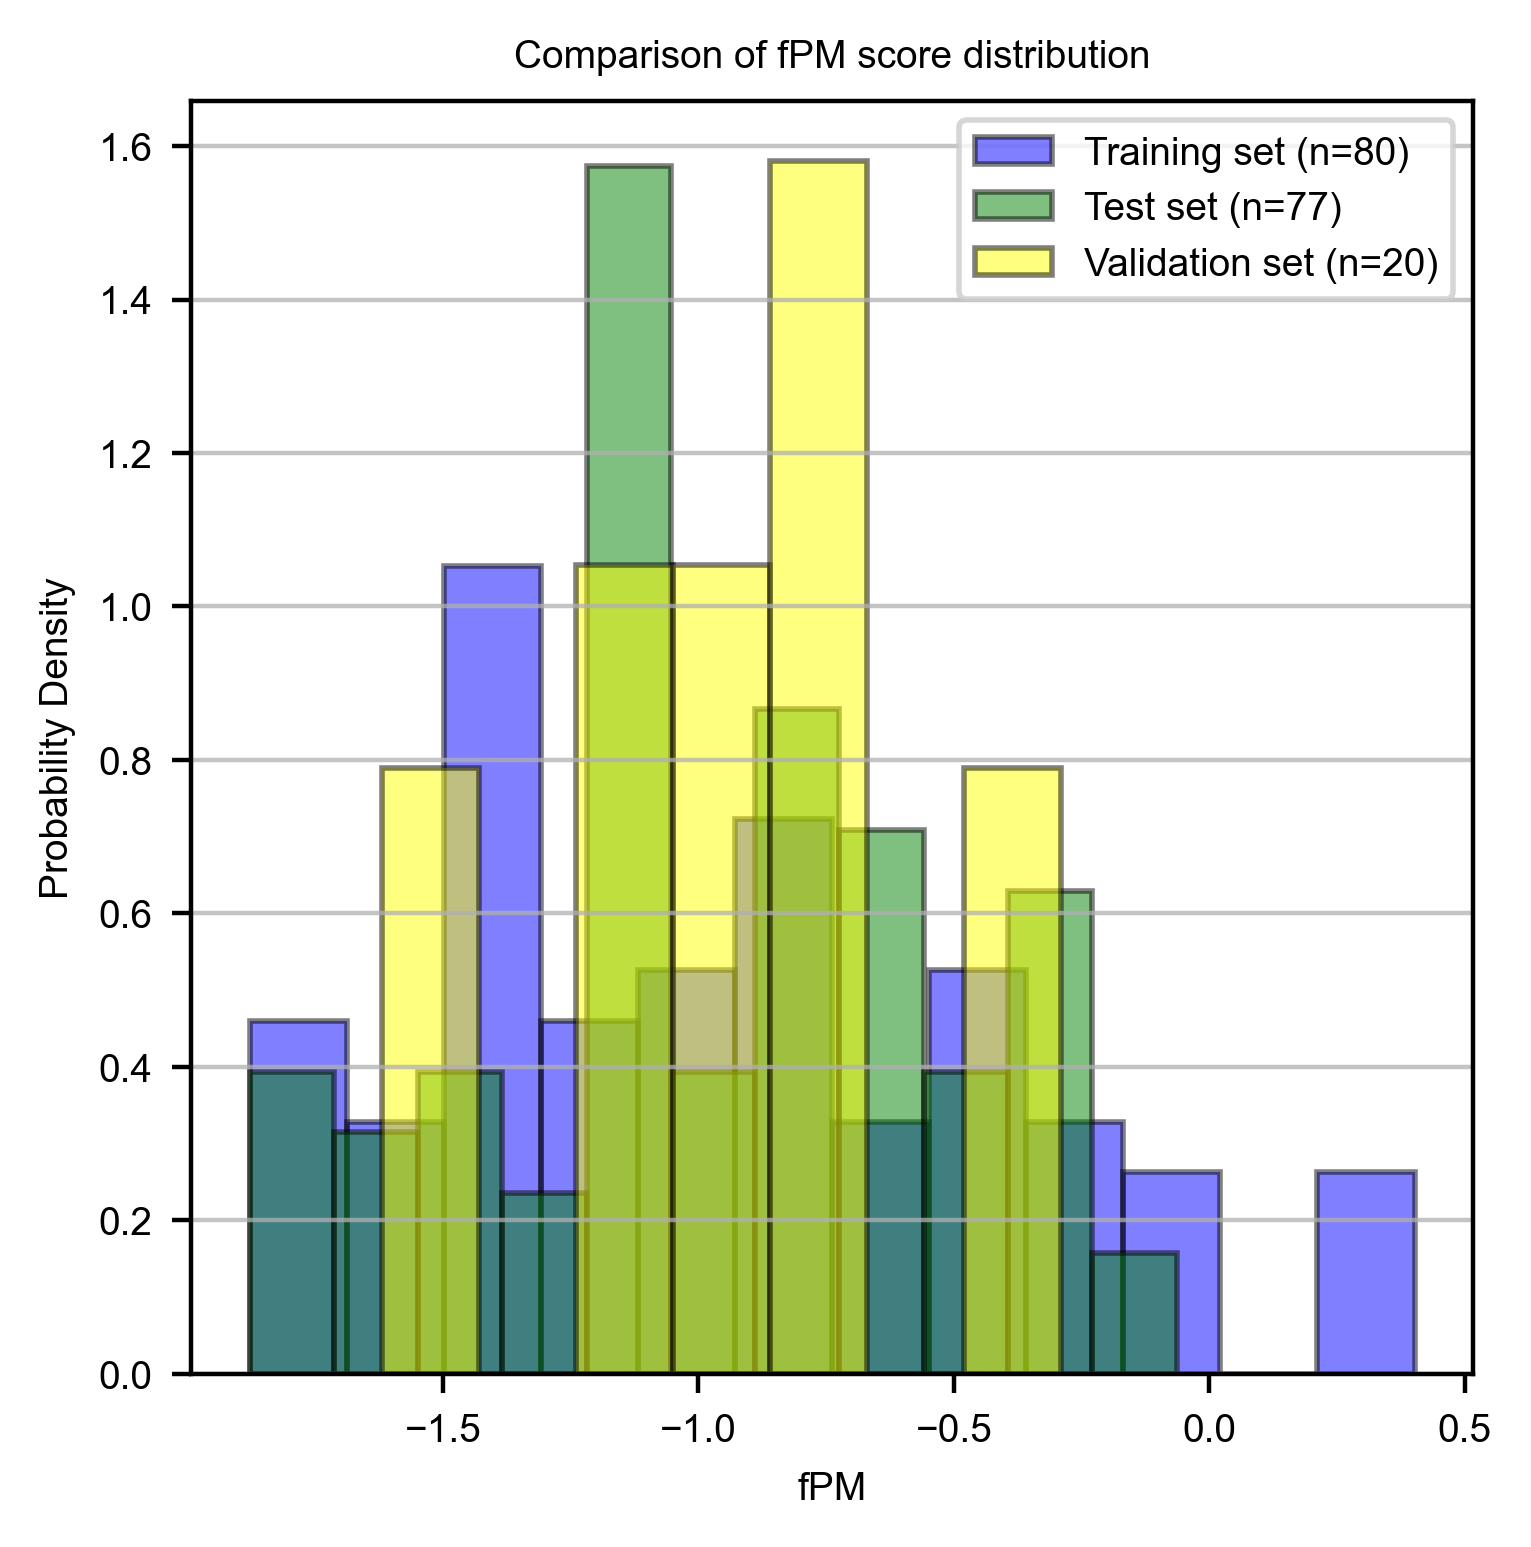

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Update default rc settings
rcParams.update({'font.size': 7, 'font.family': 'Helvetica'})
# Assuming you've already loaded the datasets
data = pd.read_csv('trainingsetrisk_score.csv')
test_data = pd.read_csv('testsetrisk_score.csv')
validation_data = pd.read_csv('validationsetrisk_score.csv')



# Create the comparison plot
plt.figure(figsize=(105/25.4, 105/25.4), dpi=400)

# Plot for the training set, with density=True for probability density
plt.hist(data['riskScore_true'], bins=12, color='blue', edgecolor='black', alpha=0.5, density=True, label='Training set (n=80)')

# Plot for the test set, with density=True for probability density
plt.hist(test_data['riskScore_true'], bins=11, color='green', edgecolor='black', alpha=0.5, density=True, label='Test set (n=77)')

# Plot for the validation set, with density=True for probability density
plt.hist(validation_data['riskScore_true'], bins=7, color='yellow', edgecolor='black', alpha=0.5, density=True, label='Validation set (n=20)')

# Add title and labels with larger font and Arial font
plt.title('Comparison of fPM score distribution', fontsize=7, fontname='Arial')
plt.xlabel('fPM', fontsize=7, fontname='Arial')
plt.ylabel('Probability Density', fontsize=7, fontname='Arial')

# Customize the tick labels for both axes
plt.xticks(fontsize=7, fontname='Arial')
plt.yticks(fontsize=7, fontname='Arial')

# Add the legend and customize it
legend = plt.legend(loc='upper right', fontsize=7)
for text in legend.get_texts():
    text.set_fontsize(7)
    text.set_fontname('Arial')

# Add grid
plt.grid(axis='y', alpha=0.75)

# Save the figure
plt.savefig('newsize_RiskScoreDistributionDensity.png')

# Display the plot
plt.show()


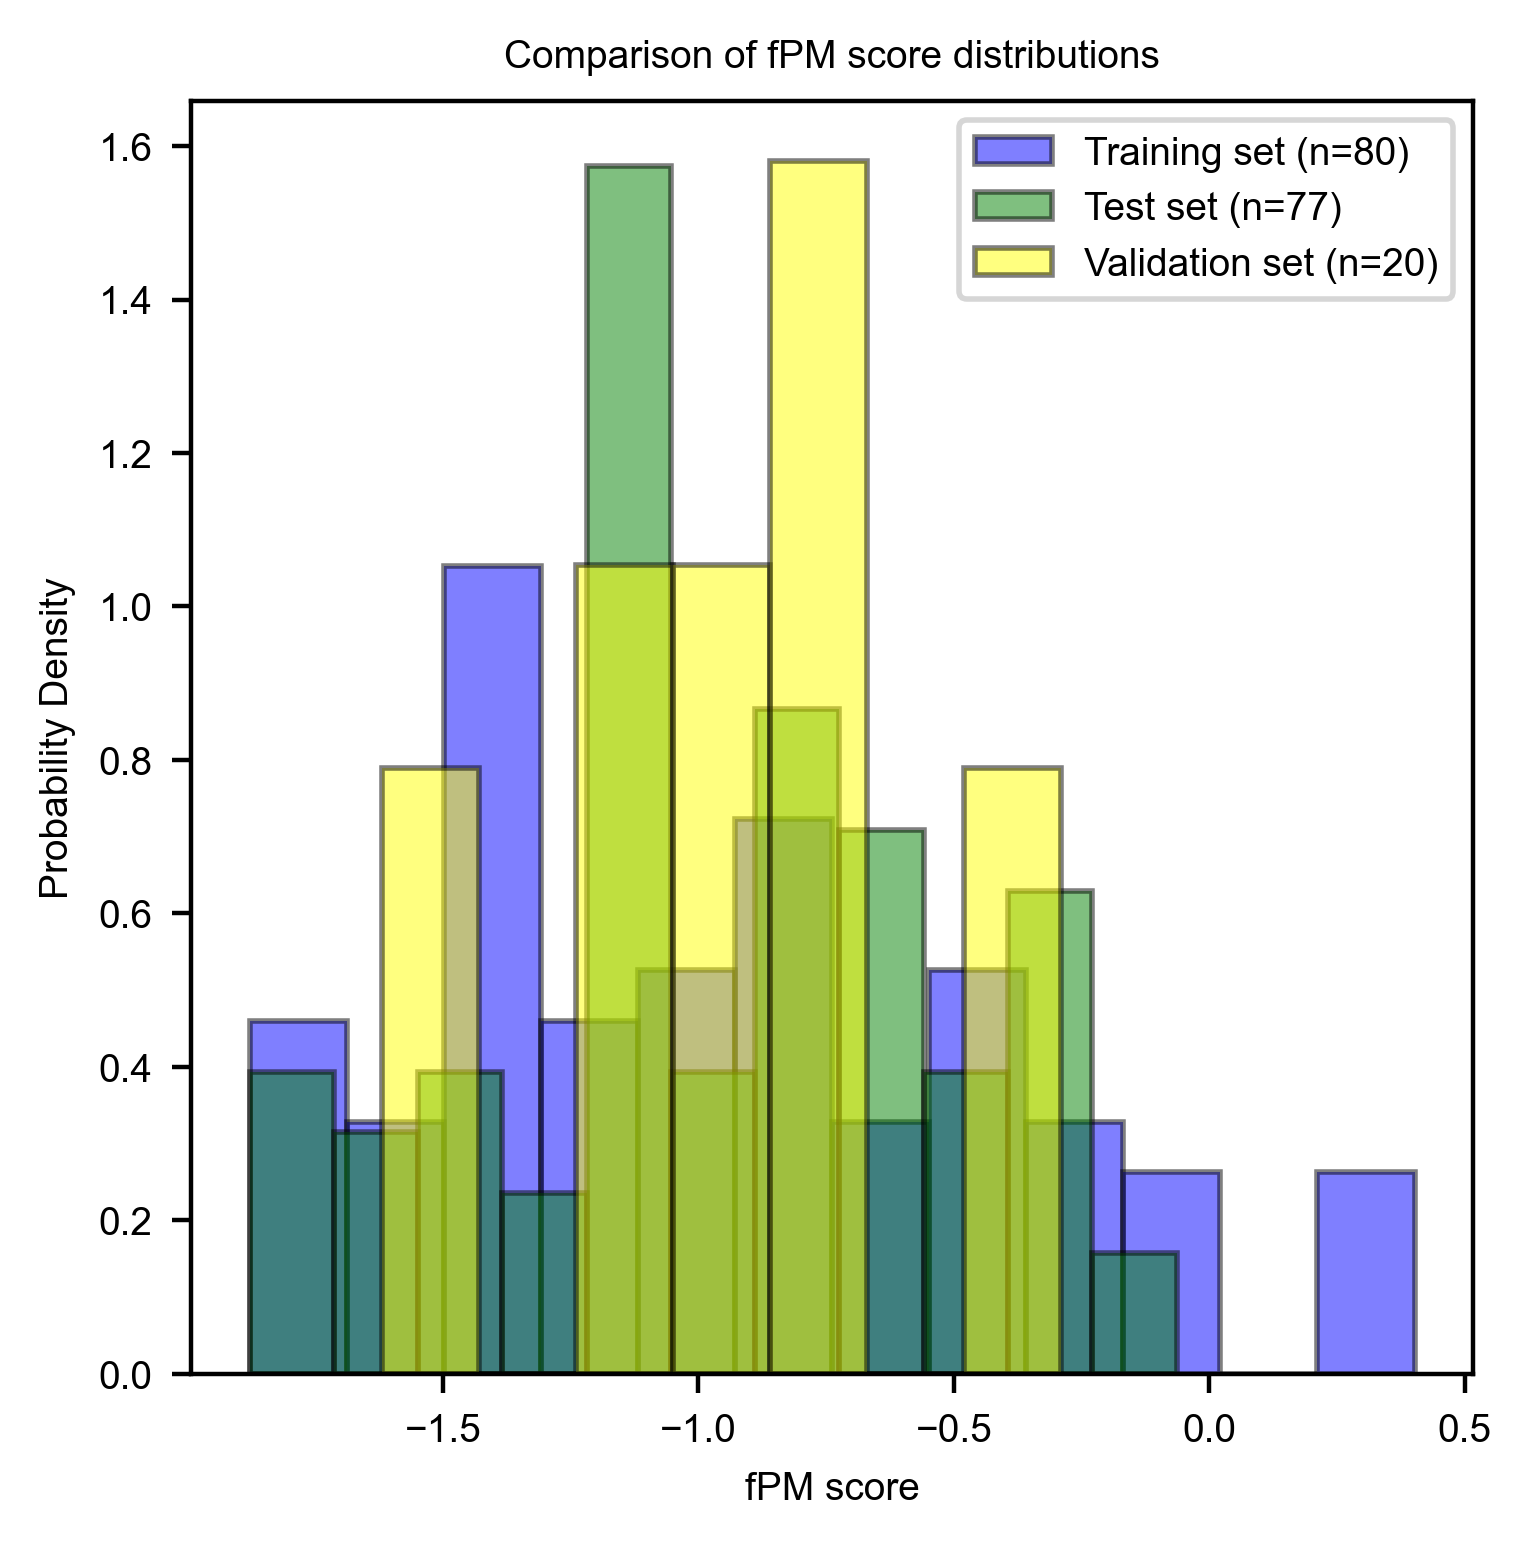

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Update default rc settings
rcParams.update({'font.size': 7, 'font.family': 'Helvetica'})
# Assuming you've already loaded the datasets
data = pd.read_csv('trainingsetrisk_score.csv')
test_data = pd.read_csv('testsetrisk_score.csv')
validation_data = pd.read_csv('validationsetrisk_score.csv')

# Create the comparison plot
plt.figure(figsize=(105/25.4, 105/25.4), dpi=400)

# Plot for the training set, with density=True for probability density
plt.hist(data['riskScore_true'], bins=12, color='blue', edgecolor='black', alpha=0.5, density=True, label='Training set (n=80)')

# Plot for the test set, with density=True for probability density
plt.hist(test_data['riskScore_true'], bins=11, color='green', edgecolor='black', alpha=0.5, density=True, label='Test set (n=77)')

# Plot for the validation set, with density=True for probability density
plt.hist(validation_data['riskScore_true'], bins=7, color='yellow', edgecolor='black', alpha=0.5, density=True, label='Validation set (n=20)')

# Add title and labels with larger font and Arial font
plt.title('Comparison of fPM score distributions', fontsize=7, fontname='Arial')
plt.xlabel('fPM score', fontsize=7, fontname='Arial')
plt.ylabel('Probability Density', fontsize=7, fontname='Arial')

# Customize the tick labels for both axes
plt.xticks(fontsize=7, fontname='Arial')
plt.yticks(fontsize=7, fontname='Arial')

# Add the legend and customize it
legend = plt.legend(loc='upper right', fontsize=7)
for text in legend.get_texts():
    text.set_fontsize(7)
    text.set_fontname('Arial')

# Remove grid by commenting out or deleting the following line
# plt.grid(axis='y', alpha=0.75)

# Save the figure
plt.savefig('newsize_RiskScoreDistributionDensity.png')

# Display the plot
plt.show()
